# **Practical session on Transfer Learning**
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# <center> Dargier Antoine </center>
# <center> Douilly Thomas </center>

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ as well as a large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

**Instructions to follow :** 

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset!)

In your final report, please *keep the logs of each training procedure* you used. We will only run this jupyter if we have some doubts on your implementation. 

The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.

You can use https://colab.research.google.com/ to run your experiments.

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt

## Training set creation
__Question 1 (2 points) :__ Propose a dataloader to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set.

Additional information :  

*   CIFAR10 dataset : https://en.wikipedia.org/wiki/CIFAR-10
*   You can directly use the dataloader framework from Pytorch.
*   Alternatively you can modify the file : https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

In [2]:
# Load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())

# Create a subset of the first 100 samples
train_subset = Subset(train_dataset, range(100))

# Create a DataLoader for the subset
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)


Files already downloaded and verified


* This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. 

* The remaining samples correspond to $\mathcal{X}$. 

* The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (1.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

Several problems can occur when the training set is small. 

First, there could be a __misrepresentation of the data__ leading to imbalanced classes in our case. All the classes are not represented equally. Let's see how the classes are represented in our training set:

Text(0.5, 1.0, 'Representation of classes in training set')

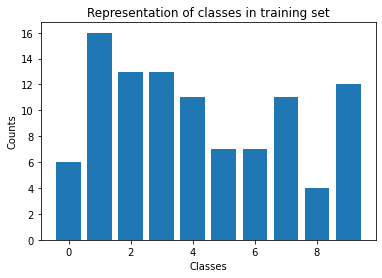

In [3]:
# Classes representation in the training set
classes = []
for batch in train_loader:
    inputs, targets = batch
    classes.extend(targets.tolist())

counts = {}

for value in classes:
    if value in counts:
        counts[value] += 1
    else:
        counts[value] = 1

#plt.figure(figsize=(10,5))
plt.bar(counts.keys(),counts.values())
plt.xlabel('Classes')
#plt.xticks(counts[0])
plt.ylabel('Counts')
plt.title('Representation of classes in training set')

One solution for that can be to using oversampling. One possibility would be to randomly duplicate data points of the minority class. One popular idea for this is SMOTE (Synthetic Minority Oversampling Technique). It doesn’t create exact duplicates of data points, but data points that lie between existing minority instances. However, oversampling can result in overfitting and may increase the time needed for training. A second solution can be to use assymetric loss function. The basic idea here is to penalize misclassification of the minority class harder than the misclassification of the majority class. Bagging and Boosting are methods that can be used too to reduce prediction errors on imbalanced datasets.

One second problem is that the dataset is just __too small to allow for generalization__. In that case we neeed to create new data, increasing the size of the dataset. One solution can be Generative Adversarial Networks (GAN’s). It is a ML model capable of generating data, consisting of two competing artificial neural networks. One has the task of generating real-looking data, the other one classifies the data as real or artificial. Data augmentation can be another good idea. The basic idea is to enhance the dataset by adding slightly modified copies of already existing data points. For images, this can be done by flipping the image horizontally or vertically, cropping and/or zooming, rotating, or changing the brightness of the image. Finally one last technique can be to use Transfer Learning. Transfer learning utilized and leverages knowledge acquired from previous tasks to solve related ones. Because the models are already pre-trained, less data is needed to solve the new problems.

# The Baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate scheduler (i.e. how to decrease the learning rate as a function of the number of epochs). A possible scheduler is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper (obviously, it is a different context for those researchers who had access to GPUs!) : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. 

## ResNet architectures

__Question 3 (4 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint :* You can re-use the following code : https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [4]:
#code coming from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def ResNet18():

    return ResNet(BasicBlock, [2, 2, 2, 2])

In [5]:
# code inspired by https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

# Training
def train(model, epochs, train_loader, verbose = True):
    
    model = model.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(model)
        cudnn.benchmark = True
        
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
    
    train_loss = []
    train_acc = []
    
    for epoch in range(epochs): 
        model.train()
        epoch_train_loss = 0
        epoch_correct = 0
        epoch_total = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            predicted_batch = outputs.argmax(dim=1)
            epoch_total += len(targets) 
            epoch_correct += (predicted_batch == targets).sum()
        epoch_acc = 100 * (epoch_correct /epoch_total)
        train_acc.append(epoch_acc.item())
        average_epochloss = epoch_train_loss/len(train_loader)
        train_loss.append(average_epochloss)

        if verbose :
            if epoch%5==0 or epoch==epochs-1:
                print('Train Epoch: {} : Loss : {:.4f} / Accuracy : {:.4f} %'.format(epoch, average_epochloss,epoch_acc))
        
    return train_acc , train_loss

# Test
def test(model, test_loader, verbose = True):
    
    model.eval()
    
    criterion = torch.nn.CrossEntropyLoss()
    
    with torch.no_grad():
        test_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            predicted_batch = outputs.argmax(dim=1)
            total += len(targets) 
            correct += (predicted_batch == targets).sum()
        test_loss = test_loss/len(test_loader)
        test_acc = 100 * (correct/total)
        if verbose :
            print('Test Results :  Loss : {} / Accuracy : {} %'.format(test_loss,test_acc))
          
    return  test_acc

In [65]:
# Hyperparameters
epochs = 20
batch_size = 20

# Loading train data set
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
train_subset = Subset(train_dataset, range(100))
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

# Loading test data set
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = ResNet18()
train_acc, train_loss = train(model, epochs, train_loader)

test_acc = test(model, test_loader)

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 0 : Loss : 2.3498 / Accuracy : 11.0000 %
Train Epoch: 5 : Loss : 0.9908 / Accuracy : 87.0000 %
Train Epoch: 10 : Loss : 0.1658 / Accuracy : 100.0000 %
Train Epoch: 15 : Loss : 0.0352 / Accuracy : 100.0000 %
Train Epoch: 19 : Loss : 0.0285 / Accuracy : 100.0000 %
Test Results :  Loss : 2.296569723367691 / Accuracy : 21.479999542236328 %


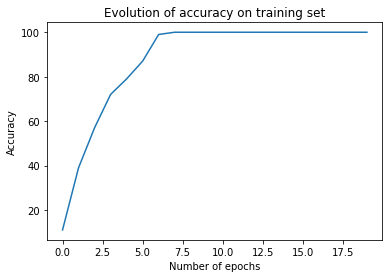

In [66]:
plt.plot(range(20), train_acc)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Evolution of accuracy on training set")
plt.show()

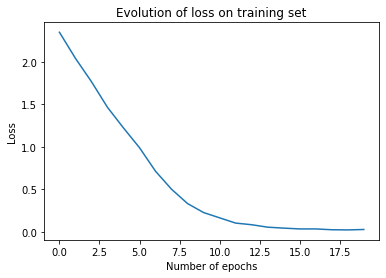

In [67]:
plt.plot(range(20), train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Evolution of loss on training set")
plt.show()

Here are our results, compared to a reference paper:

| Paper | Model | Number of  epochs  | Train accuracy | Test accuracy |
|:------:|:------:|:------:|:------:|:------:|
|/|   ResNet18  | 20 | 100% | 21.48% |
|https://tinyurl.com/Link-paper|   ResNet18  | 50 | 98% | 92.36% |


We can here conclude that our model is clearly overfitting with a 100% accuracy on the train set, but very poor performances on the test set. We need so to find solutions to improve the performances of the model. We will first try Transfer Learning, and then Data Augmentation.

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on : https://pytorch.org/vision/stable/models.html.

__Question 4 (3 points):__ Pick a model from the list above, adapt it for CIFAR10 and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In this part, we will try to use a ResNet34 model as baseline and retrain its final layer. We will keep the hyperparameters from last part, ie a batch size equal to 20, a momentum of 0.9 and a learning rate of 0.1 decreasing from 10 each 30 batches.

The main steps of transfer learning that we will compute are:
* choose a pre-trained model
* remove the last two layers
* add two fully connected layers
* freeze all the layers and train the two new layers for this new task
* unfreeze the model and train the whole architecture

In [6]:
class Net(nn.Module):

    def __init__(self, model):
        super().__init__()

        # Baseline model
        if model == "ResNet34":
            self.model = models.resnet34(pretrained=True)
        
        # Remove last 2 layers
        self.num_filters = self.model.fc.in_features
        self.layers = list(self.model.children())[:-2]
        self.backbone = nn.Sequential(*self.layers)

        # Added fully connected layers 
        self.fc1 = nn.Linear(self.num_filters, 64) 
        self.fc = nn.Linear(64, 10)  

    def forward(self, x):

        x = self.backbone(x)
        x = x.squeeze(3)
        x = x.squeeze(2)
        x = self.fc1(x)
        x = self.fc(x)

        return x

In [7]:
def train_TL(model, epochs, verbose=True) : 
    
    model = Net(model)

    #TRAIN
    print("="*54)
    print("TRAIN")

    for param in model.parameters():
        param.requires_grad = False

    for param in model.fc.parameters():
        param.requires_grad = True
  
    for param in model.fc1.parameters():
        param.requires_grad = True
    
    print("training of last 2 layers")
    train_acc1 , train_loss1 = train(model, epochs, train_loader)
    
    for param in model.parameters():
        param.requires_grad = True
    print("training of the whole model")
    train_acc2 , train_loss2 = train(model,epochs, train_loader) 

    if verbose : 
        
        plt.plot(range(2*epochs), train_acc1+train_acc2)
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy")
        plt.title("Evolution of accuracy on training set")
        plt.show()
        
        plt.plot(range(2*epochs), train_loss1+train_loss2)
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss")
        plt.title("Evolution of loss on training set")
        plt.show()

    #TEST
    print("="*54)
    print("TEST")
    
    test_accuracy = test(model, test_loader)

TRAIN
training of last 2 layers
Train Epoch: 0 : Loss : 2.4968 / Accuracy : 6.0000 %
Train Epoch: 5 : Loss : 2.0494 / Accuracy : 31.0000 %
Train Epoch: 10 : Loss : 1.7103 / Accuracy : 51.0000 %
Train Epoch: 15 : Loss : 1.4672 / Accuracy : 59.0000 %
Train Epoch: 20 : Loss : 1.2797 / Accuracy : 65.0000 %
Train Epoch: 25 : Loss : 1.0539 / Accuracy : 75.0000 %
Train Epoch: 29 : Loss : 0.9499 / Accuracy : 83.0000 %
training of the whole model
Train Epoch: 0 : Loss : 0.9680 / Accuracy : 79.0000 %
Train Epoch: 5 : Loss : 0.2398 / Accuracy : 99.0000 %
Train Epoch: 10 : Loss : 0.0522 / Accuracy : 100.0000 %
Train Epoch: 15 : Loss : 0.0298 / Accuracy : 100.0000 %
Train Epoch: 20 : Loss : 0.0261 / Accuracy : 100.0000 %
Train Epoch: 25 : Loss : 0.0163 / Accuracy : 100.0000 %
Train Epoch: 29 : Loss : 0.0228 / Accuracy : 100.0000 %


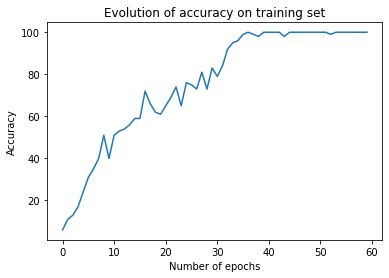

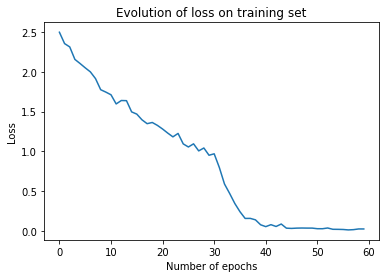

TEST
Test Results :  Loss : 2.598676997184753 / Accuracy : 27.270000457763672 %


In [64]:
model = "ResNet34"
train_TL(model, 30, verbose=True)

When training a model with transfer learning, an issue can be a decreasing of accuracy when we begin to train the whole architecture. On reason can be forgetting last weights of the pretrained model: that is called catastrophic forgetting.

In our case, there is a big improvement of the accuracy when training the whole model (from epoch 30). We don't have a forgetting problem, and so transfer learning is useful. That is confirmed by the results on test set, which are much better.

Here are our results for the transfer learning:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|:------:|:------:|:------:|:------:|
|   ResNet34  | 60 | 100% | 27.27% |

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that :

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to :

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 5 (1.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

Several issues can appeared when dealing with translations, rotations, scaling effects or color changes. Here are some of these problems and ideas to tackle them:
* translation : when dealing with translation, there can be issues with boundaries when the image is translated to far from limited boundaries. There can be also a loss of context, of alignement between elements and it can create biais if the translation occurs more importantly in a direction. For that, we can limit the range of translation, use cropping to remove any out-of-bounds objects, use interpoliation or padding.
* rotation : rotation can distort the shapes of the images, some part (corners) can be cropped out too, and there can also be a biais if a rotation direction is priveleged. To avoid that, we can use interpolations tools and padding.
* scaling effects : with scaling effects, one can lose some information when the images is too far from original boundaries. There can be a loss of resolutio too, distortion making elements difficult to recognize. To avoid that, we can set limits on how the images is scaled, used proportional scaling to preserve sizes of elements, and use interpolation to limit the loss od resolution.
* color changes : changing the color in RGB, the channels are modified differently and it thus creates distorted colors. Moreover, it can create over-saturation and loss of contrast. To avoid that, we can use color normalization or histogram equalization to preserve the distribution. Another solution can be to convert the image in a well-known space of colors, such as YUV.

## Data augmentations

__Question 6 (3 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

In [8]:
# Data transformations implemented as https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
train_transformations = torchvision.transforms.Compose([
                 torchvision.transforms.RandomHorizontalFlip(),
                 torchvision.transforms.RandomCrop(size=[32,32], padding=3),
                 torchvision.transforms.GaussianBlur(kernel_size=(3,3)),
                 torchvision.transforms.ColorJitter(hue=.1),
                 torchvision.transforms.ToTensor(),
                 torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                 ])

test_transformations = torchvision.transforms.Compose([
                 torchvision.transforms.ToTensor(),
                 torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                 ])

In [12]:
epochs = 40
batch_size = 20

# Loading train data set
train_dataset_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transformations)
train_subset_aug = Subset(train_dataset_aug, range(100))
train_loader_aug = DataLoader(train_subset_aug, batch_size=batch_size, shuffle=True)

# Loading test data set
test_dataset_aug = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transformations)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=batch_size, shuffle=False)

model = ResNet18()
train_acc, train_loss = train(model, epochs, train_loader_aug)

test_acc = test(model, test_loader_aug)

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 0 : Loss : 2.3059 / Accuracy : 14.0000 %
Train Epoch: 5 : Loss : 1.8536 / Accuracy : 43.0000 %
Train Epoch: 10 : Loss : 1.4469 / Accuracy : 50.0000 %
Train Epoch: 15 : Loss : 1.0511 / Accuracy : 74.0000 %
Train Epoch: 20 : Loss : 0.8047 / Accuracy : 78.0000 %
Train Epoch: 25 : Loss : 0.5689 / Accuracy : 84.0000 %
Train Epoch: 30 : Loss : 0.4061 / Accuracy : 89.0000 %
Train Epoch: 35 : Loss : 0.3890 / Accuracy : 92.0000 %
Train Epoch: 39 : Loss : 0.2074 / Accuracy : 95.0000 %
Test Results :  Loss : 3.6715293483734133 / Accuracy : 24.68000030517578 %


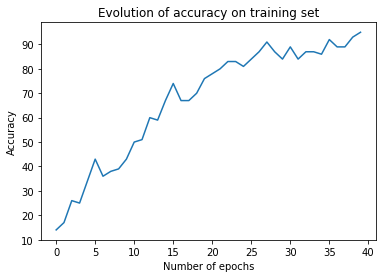

In [14]:
plt.plot(range(40), train_acc)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Evolution of accuracy on training set")
plt.show()

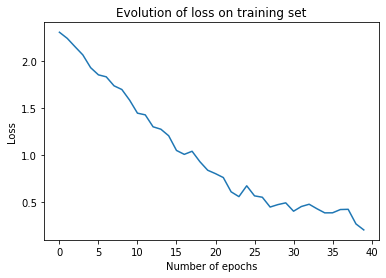

In [15]:
plt.plot(range(40), train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Evolution of loss on training set")
plt.show()

# Conclusions

__Question 7 (5 points) :__ Write a short report explaining the pros and the cons of each method that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

__1) Implementation of ResNet18 from scratch__

When we implement ResNet18 from scratch with our small train set, we can see that the model is clearly overfitting: we have 100% accuracy on the train set, but only 21.48% on the test set. So we need to find solutions to this issues. A first one can be transfer learning from a pretrained model ; a second one can be to try data augmentation to have a bigger train set.

__2) Transfer Learning with pretrained ResNet34__

After this first analysis, we try to use a pretrained model. We choose ResNet34 model, which we adapt to our task with transfer learning: we create new layers that we train alone in a first part, before learning the whole model to our task. With this method, we achieve to reach 100% accuracy on the train set, and 27.27% on the test set. We can see now that transfer learning is a good solution when train set is very small, because there is always overfitting but the results are better on the test set.

__3) Data augmentation__

Finally, we tried data augmentation to improve the size of our training set. We implement transformations on our data, such as andomHorizontalFlip, RandomCrop, GaussianBlur, ColorJitter. This method seems here pretty efficient, because we succeed to achieve very good performance, with 95% accuracy on our train set, and 24.68% on the test set in 40 epochs. So the performance on the train set is a little bit lower, but the generalization on the test set is better.

| Model | Number of  epochs | Train accuracy | Test accuracy |
|:------:|:------:|:------:|:------:|
|   ResNet18 from scratch  | 20 | 100% | 21.48% |
|   ResNet34 with Transfer Learning | 60 | 100% | 27.27% |
|   ResNet18 with Data Augmentation  | 40 | 95% | 24.68% |
    
Finally, in our case, the Transfer Learning method seems to be the better regarding to the results achieved. It could be interesting to combine the different method to see if we can reach higher performances.

# Weak supervision

__Bonus \[open\] question (up to 3 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.